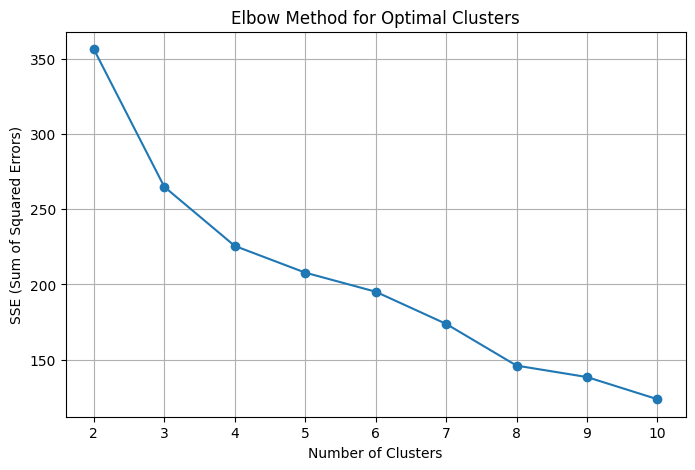

Davies-Bouldin Index: 1.31
Silhouette Score: 0.24


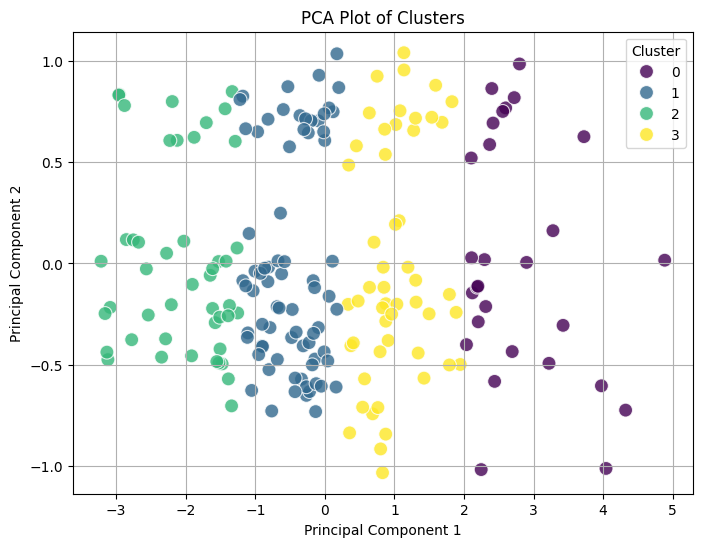

<ipython-input-1-4c0b7c98f79f>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='TotalValue', data=customer_features, palette='viridis')


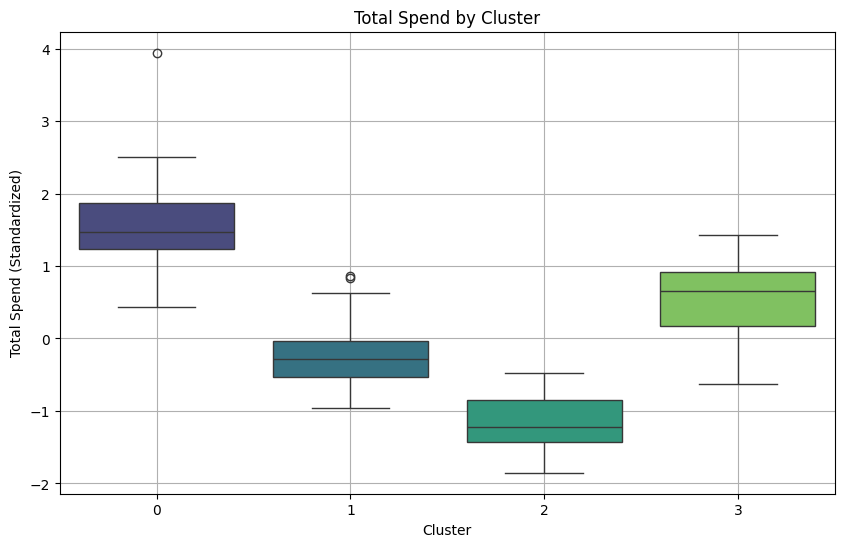

Clustering results and visualizations completed.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Convert date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID')

# Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum',    # Total quantity purchased
    'ProductID': 'count', # Total transactions
    'Region': 'first',    # Region
}).reset_index()

# Rename ProductID count column for clarity
customer_features.rename(columns={'ProductID': 'TransactionCount'}, inplace=True)

# Encode categorical variable (Region)
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_columns = ['TotalValue', 'Quantity', 'TransactionCount']
customer_features[numerical_columns] = scaler.fit_transform(customer_features[numerical_columns])

# Prepare data for clustering (drop CustomerID)
clustering_data = customer_features.drop('CustomerID', axis=1)

# Elbow Method to find the optimal number of clusters
sse = []
k_range = range(2, 11)  # Between 2 and 10 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    sse.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid()
plt.show()

# Final Clustering with optimal clusters
optimal_clusters = 4  # Based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(clustering_data)

# Clustering Metrics
db_index = davies_bouldin_score(clustering_data, customer_features['Cluster'])
silhouette_avg = silhouette_score(clustering_data, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")

# Visualization: PCA Plot
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data)
customer_features['PCA1'] = pca_data[:, 0]
customer_features['PCA2'] = pca_data[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_features,
    palette='viridis', s=100, alpha=0.8
)
plt.title('PCA Plot of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Visualization: Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='TotalValue', data=customer_features, palette='viridis')
plt.title('Total Spend by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spend (Standardized)')
plt.grid()
plt.show()

# Save results
customer_features.to_csv('Customer_Segmentation_Results.csv', index=False)

print("Clustering results and visualizations completed.")
